# Import tools

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import graphviz
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import interp
from pandas import set_option
# set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None


In [2]:
mpl.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
set_option("display.max_rows", 15)
set_option('display.width', 200)
np.set_printoptions(suppress=True, threshold=5000)

# Exploring the dataset

In [3]:
TrainDataPath = 'facies_data/train/'

In [4]:
filename_AB = '古页-1_facies_vectors_0.1.csv'   # facies_vectors.csv
TrainDataPath = os.path.join(TrainDataPath,filename_AB)
print(TrainDataPath)

facies_data/train/古页-1_facies_vectors_0.1.csv


In [5]:
input_vectors = ["GR","CNL","DT","DEN","MSFL","RS","RD"]


In [6]:
training_data = pd.read_csv(TrainDataPath,engine='python',encoding='GBK')

In [7]:
blind = training_data[training_data['Well Name'] == '34']
# training_data = training_data[training_data['Well Name'] != '58']
training_data = training_data[training_data['Well Name'] != '34']

In [8]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
# training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

['GY1']
Categories (1, object): ['GY1']

In [9]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
# facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
#        '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']


facies_colors = ['#632423', '#0070C0','#00B0F0','#75DAFF','#00B050','#FFC000', '#FFFF00']

# facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
#                  'WS', 'D','PS', 'BS']

facies_labels = ['高有机质层状页岩相', '高有机质纹层状页岩相','中有机质纹层状页岩相','低有机质纹层状页岩相',
                '中低有机质块状白云岩相', '低有机质块状介壳灰岩相', '低有机质块状粉砂岩相']

adjacent_facies = np.array([[0],[1], [0,1], [1,2,3], [4], [5], [5,6]])
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
training_data.describe()

C:\Users\xbs\AppData\Local\Temp\ipykernel_19664\4084507913.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  adjacent_facies = np.array([[0],[1], [0,1], [1,2,3], [4], [5], [5,6]])


,DEPTH,CAL,SP,GR,CNL,DT,DEN,MSFL,RS,RD,Facies
count,2821.000000,2821.000000,2821.000000,2821.000000,2821.000000,2821.000000,2821.000000,2821.000000,2821.000000,2821.000000,2821.000000
mean,2445.500000,9.357501,103.187203,131.246154,20.825650,98.068841,2.459156,6.473690,6.812904,6.588174,2.004608
std,81.449688,0.611695,2.777722,8.752048,2.734928,8.916693,0.094956,6.823788,2.319722,2.219460,1.253780
min,2304.500000,8.657000,95.300000,74.400000,7.960000,63.200000,1.993800,1.532000,3.594000,3.870000,0.000000
25%,2375.000000,9.019000,101.200000,126.400000,19.440000,93.000000,2.409600,3.580000,5.462000,5.330000,1.000000
50%,2445.500000,9.155000,103.200000,131.400000,20.980000,97.600000,2.471600,5.516000,6.202000,6.088000,2.000000
75%,2516.000000,9.457400,105.440000,136.600000,22.400000,103.600000,2.525000,7.206000,7.620000,7.282000,3.000000
max,2586.500000,13.796000,109.260000,156.400000,34.860000,131.000000,2.673800,139.690000,30.160000,29.540000,6.000000


In [10]:
# PE_mask = training_data['PE'].notnull().values
# training_data = training_data[PE_mask]

In [11]:
# 岩相所在列
facies_labels_col = "Facies"
# 深度列名称
DEPTH_col_name = "DEPTH"

In [12]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by = DEPTH_col_name)
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs[DEPTH_col_name].min(); zbot=logs[DEPTH_col_name].max()
    
    cluster = np.repeat(np.expand_dims(logs[facies_labels_col].values,1), 100, 1)
    total_fig_cols = len(input_vectors)+ 1
    f, ax = plt.subplots(nrows=1, ncols = total_fig_cols, figsize=(total_fig_cols * 2,15))
    for i in range(len(input_vectors)):
        ax[i].plot(logs[input_vectors[i]], logs[DEPTH_col_name])
    final_line = len(input_vectors)
    im = ax[final_line].imshow(cluster, interpolation='none', aspect='auto',
                               cmap=cmap_facies,vmin = 1,vmax = len(facies_colors))
    
    divider = make_axes_locatable(ax[final_line])
    cax = divider.append_axes("right", size="25%", pad=0.05)
    # cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    # cbar.set_label((17*' ').join(facies_labels))
    cbar.set_label((4*' ').join(facies_labels))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
        ax[i].set_xlabel(input_vectors[i])
        ax[i].set_xlim(logs[input_vectors[i]].min(),logs[input_vectors[i]].max())
        
    ax[final_line].set_xlabel('Facies')
    
    for i in range(len(ax)-1):
        ax[i].set_yticklabels([]);
        
    ax[final_line].set_yticklabels([])
    ax[final_line].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

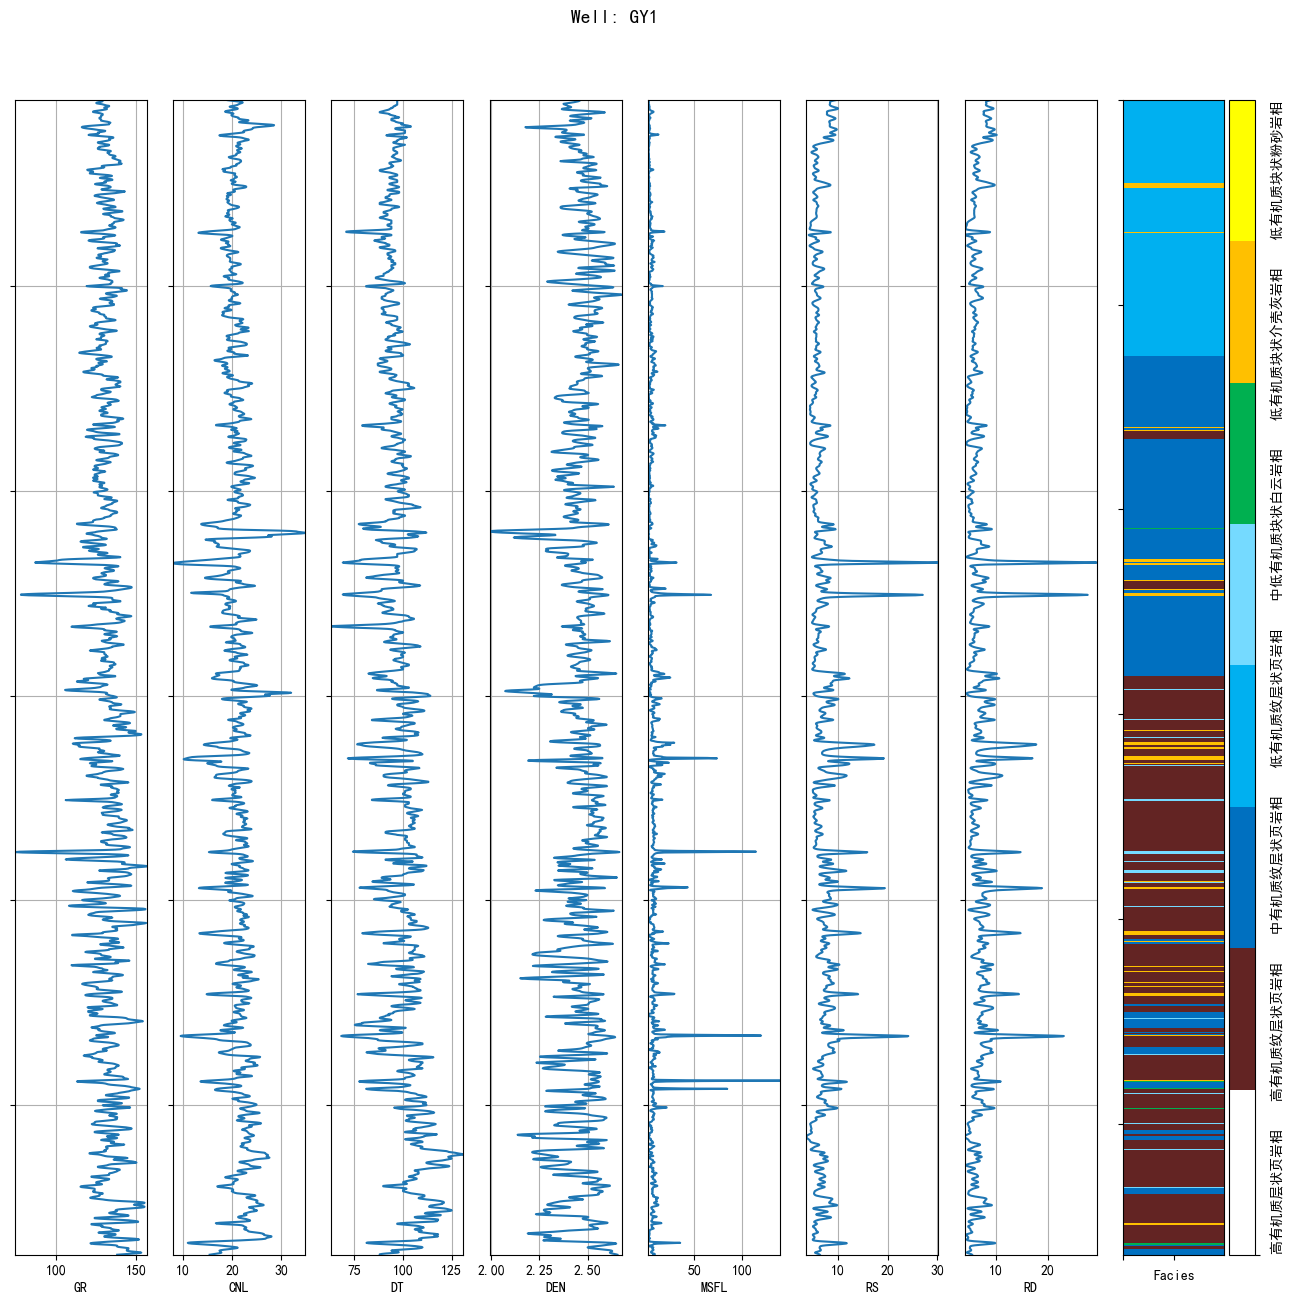

In [13]:
make_facies_log_plot(
    training_data[training_data['Well Name'] == 'GY1'],
    facies_colors)

In [14]:
# make_facies_log_plot(
#     training_data[training_data['Well Name'] == '58'],
#     facies_colors)

高有机质层状页岩相        95
高有机质纹层状页岩相     1072
中有机质纹层状页岩相      844
低有机质纹层状页岩相      610
中低有机质块状白云岩相      58
低有机质块状介壳灰岩相      19
低有机质块状粉砂岩相      123
Name: Facies, dtype: int64

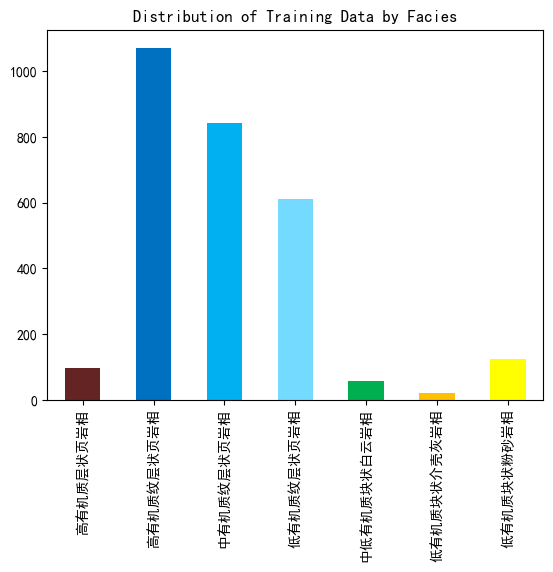

In [15]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by Facies')
facies_counts

d:\Program Files\Python310\lib\site-packages\seaborn\axisgrid.py:142: UserWarning: Glyph 20302 (\N{CJK UNIFIED IDEOGRAPH-4F4E}) missing from current font.
  self.fig.draw(self.fig.canvas.get_renderer())
d:\Program Files\Python310\lib\site-packages\seaborn\axisgrid.py:142: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from current font.
  self.fig.draw(self.fig.canvas.get_renderer())
d:\Program Files\Python310\lib\site-packages\seaborn\axisgrid.py:142: UserWarning: Glyph 26426 (\N{CJK UNIFIED IDEOGRAPH-673A}) missing from current font.
  self.fig.draw(self.fig.canvas.get_renderer())
d:\Program Files\Python310\lib\site-packages\seaborn\axisgrid.py:142: UserWarning: Glyph 36136 (\N{CJK UNIFIED IDEOGRAPH-8D28}) missing from current font.
  self.fig.draw(self.fig.canvas.get_renderer())
d:\Program Files\Python310\lib\site-packages\seaborn\axisgrid.py:142: UserWarning: Glyph 22359 (\N{CJK UNIFIED IDEOGRAPH-5757}) missing from current font.
  self.fig.draw(self.fig.canvas.g

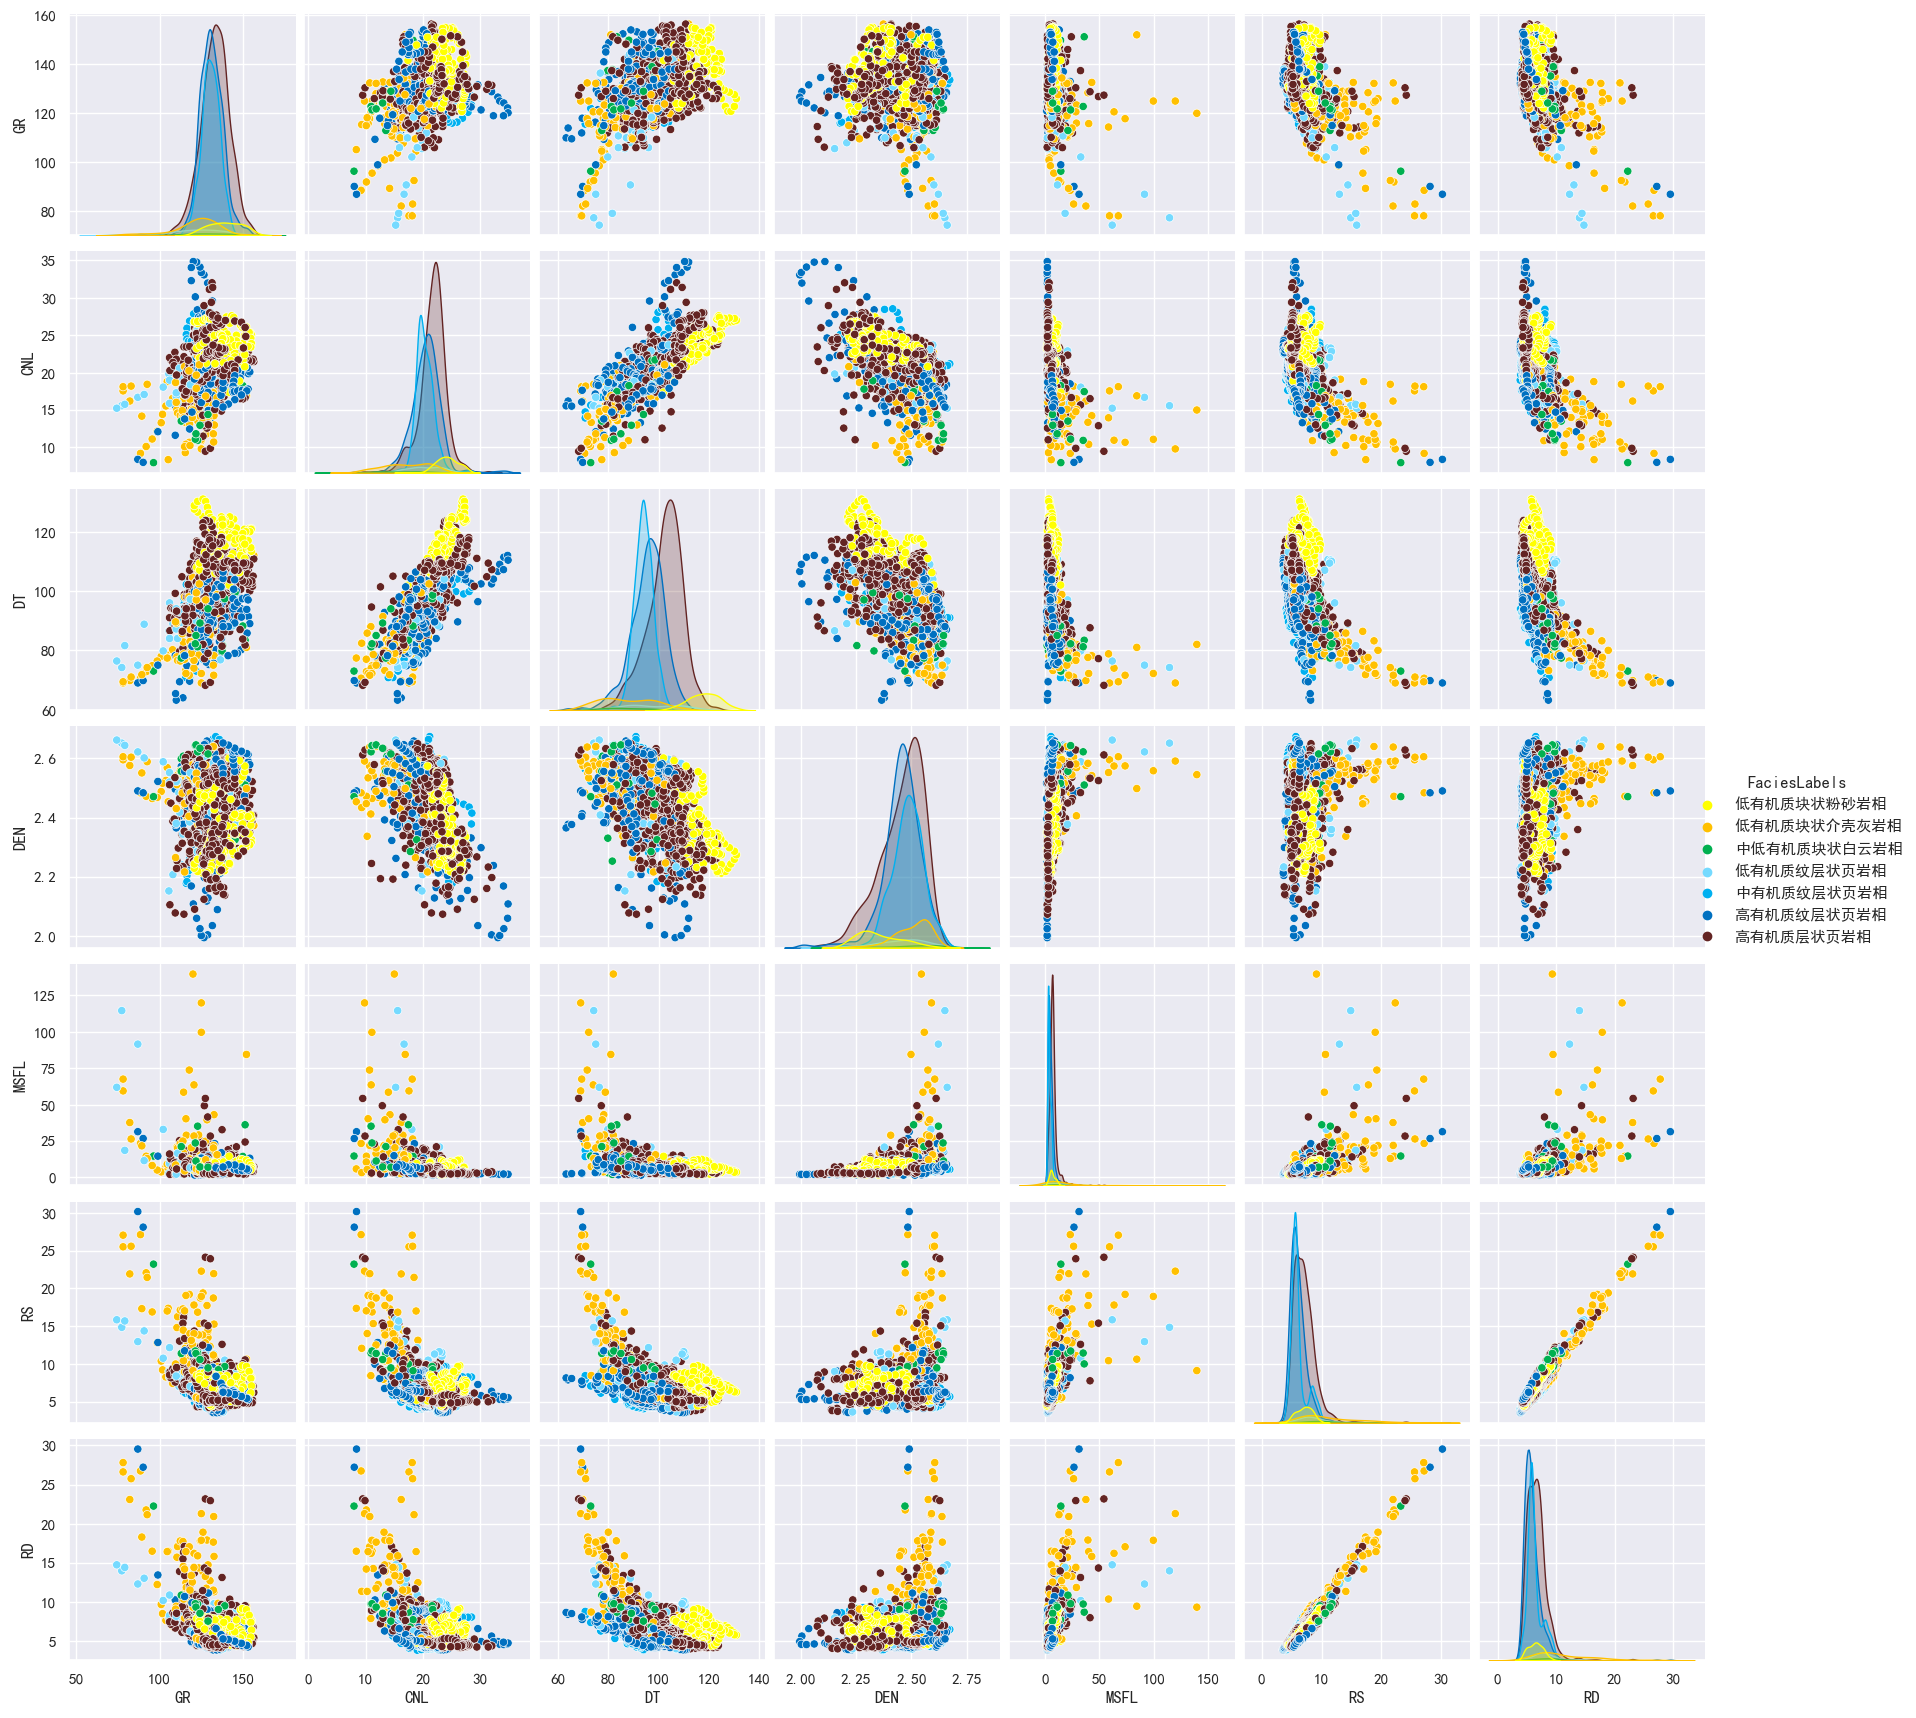

In [16]:
#save plot display settings to change back to when done plotting with seaborn
inline_rc = dict(mpl.rcParams)

import seaborn as sns
sns.set()
sns.pairplot(training_data.drop(['Well Name','Facies','DEPTH','CAL','SP'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))

#switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)

In [17]:
correct_facies_labels = training_data['Facies'].values

# feature_vectors = training_data.drop(['Formation', 'Well Name', 'DEPTH','Facies','FaciesLabels'], axis=1)
feature_vectors = training_data[input_vectors]
feature_vectors.describe()

,GR,CNL,DT,DEN,MSFL,RS,RD
count,2821.000000,2821.000000,2821.000000,2821.000000,2821.000000,2821.000000,2821.000000
mean,131.246154,20.825650,98.068841,2.459156,6.473690,6.812904,6.588174
std,8.752048,2.734928,8.916693,0.094956,6.823788,2.319722,2.219460
min,74.400000,7.960000,63.200000,1.993800,1.532000,3.594000,3.870000
25%,126.400000,19.440000,93.000000,2.409600,3.580000,5.462000,5.330000
50%,131.400000,20.980000,97.600000,2.471600,5.516000,6.202000,6.088000
75%,136.600000,22.400000,103.600000,2.525000,7.206000,7.620000,7.282000
max,156.400000,34.860000,131.000000,2.673800,139.690000,30.160000,29.540000


In [18]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

In [19]:
feature_vectors

,GR,CNL,DT,DEN,MSFL,RS,RD
0,128.0,18.60,96.0,2.4600,2.170,10.020,9.440
1,128.0,19.00,96.8,2.4600,2.034,9.548,9.040
2,128.6,19.58,97.0,2.4582,2.006,9.118,8.664
3,129.0,20.30,97.0,2.4546,2.086,8.778,8.364
4,128.8,21.06,97.0,2.4488,2.242,8.546,8.160
...,...,...,...,...,...,...,...
2816,152.2,17.56,93.8,2.6162,5.766,5.492,4.482
2817,149.0,17.02,91.2,2.6242,7.284,5.734,4.746
2818,145.0,16.38,89.2,2.6346,8.520,5.994,5.014
2819,141.2,15.80,88.0,2.6448,8.676,6.204,5.222


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.2, random_state=42)

In [21]:
y_train

array([2, 0, 1, 2, 6, 2, 1, 4, 3, 1, 3, 1, 2, 2, 3, 1, 1, 1, 3, 3, 2, 2,
       2, 2, 3, 0, 1, 1, 2, 3, 2, 1, 2, 2, 1, 3, 1, 1, 1, 1, 1, 1, 4, 1,
       1, 1, 1, 2, 3, 2, 1, 3, 2, 6, 1, 2, 1, 1, 6, 3, 3, 2, 1, 2, 2, 2,
       2, 1, 2, 3, 2, 1, 3, 6, 2, 1, 1, 6, 1, 3, 1, 1, 3, 3, 1, 2, 1, 1,
       2, 5, 1, 3, 3, 1, 2, 1, 2, 2, 3, 1, 2, 2, 1, 1, 2, 1, 1, 3, 1, 1,
       2, 5, 4, 1, 3, 1, 1, 4, 3, 3, 3, 1, 2, 3, 1, 1, 2, 2, 2, 1, 1, 2,
       6, 2, 1, 3, 1, 2, 2, 2, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 2, 1, 1, 3,
       1, 4, 1, 1, 2, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 2,
       1, 3, 1, 3, 2, 3, 0, 2, 2, 1, 3, 0, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1,
       6, 2, 1, 6, 1, 1, 2, 3, 6, 2, 4, 2, 4, 1, 1, 1, 1, 4, 3, 1, 1, 3,
       3, 5, 1, 1, 3, 1, 3, 1, 2, 2, 3, 2, 4, 2, 2, 1, 1, 3, 1, 2, 3, 2,
       2, 3, 1, 1, 3, 3, 1, 3, 1, 1, 0, 3, 3, 1, 6, 1, 1, 0, 2, 6, 1, 1,
       1, 3, 0, 2, 1, 3, 2, 1, 2, 1, 3, 3, 2, 1, 2, 1, 1, 2, 1, 2, 1, 6,
       2, 6, 1, 1, 2, 2, 2, 1, 2, 3, 3, 2, 1, 3, 3,

# Training the xgboost  classifier

In [22]:
import xgboost as xgb 
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

In [23]:

# Parameter Tuning
clf = xgb.XGBClassifier()
param_dist = {"max_depth": [10,30,50],
              # "min_child_weight" : [1,3,6],
              "n_estimators": [100,200],
              "learning_rate": [0.0002,0.05, 0.1,0.16],}
grid_search = RandomizedSearchCV(clf, param_distributions = param_dist, cv = 3, verbose=10, n_jobs=-1)
grid_search.fit(X_train,y_train)



Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.0002, 0.05, 0.1,
                                                          0.16],
                                        'max_depth': [10, 30, 50],
                                        'n_estimators': [100, 200]},
                   verbose=10)

In [24]:
best_estimator = grid_search.best_estimator_

print(best_estimator)
#输出最优训练器的精度
print(grid_search.best_score_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=50, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)
0.8164893617021276


In [25]:
clf = xgb.XGBClassifier(max_depth=50, min_child_weight=1,  n_estimators=200, n_jobs=-1 , verbose=1,learning_rate=0.16)


clf.fit(X_train,y_train)

[22:33:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.16, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=50, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [26]:
training_img_file_saving_path = 'model_training_images/'
child_dir_name ="xgboost" + "_"  + "training/"
model_training_img_file_saving_path = os.path.join(training_img_file_saving_path,child_dir_name)
model_training_img_name =   "xgboost"  + "_"  
    
if not os.path.exists(model_training_img_file_saving_path):
    os.mkdir(model_training_img_file_saving_path)
        
model_testing_image_name =  "xgboost" + "_" 
child_dir_name =  "xgboost" + "_"  + "testing/"
testing_img_file_saving_path = 'model_testing_images/'
model_testing_img_file_saving_path = os.path.join(testing_img_file_saving_path,child_dir_name)
if not os.path.exists(model_testing_img_file_saving_path):
    os.mkdir(model_testing_img_file_saving_path)

In [27]:
model_save_path = os.path.join("model/", 'facies_xgboost'  + "_train/")
#model_save_path = os.path.join("model/", 'facies_' + model_type.lower() + "_train/",child_dir_name)
if os.path.exists(model_save_path):
    model_path = model_save_path
else:
    os.mkdir(model_save_path)
    model_path = model_save_path
print(model_path)

model/facies_xgboost_train/


In [28]:
model_name = 'facies_xgboost_'
model_file = model_path + model_name + '.pkl'
print("model_name:",model_name)
print("model_file:",model_file)

model_name: facies_xgboost_
model_file: model/facies_xgboost_train/facies_xgboost_.pkl


In [29]:
predicted_labels = clf.predict(X_test)

In [30]:
clf.score(X_test,predicted_labels)

1.0

In [31]:
from sklearn.metrics import confusion_matrix
from classification_utilities import display_cm, display_adj_cm

conf = confusion_matrix(y_test, predicted_labels)
display_cm(conf, facies_labels, hide_zeros=True)

     Pred   高有机质层状页岩相  高有机质纹层状页岩相  中有机质纹层状页岩相  低有机质纹层状页岩相 中低有机质块状白云岩相 低有机质块状介壳灰岩相  低有机质块状粉砂岩相       Total
     True
      高有机质层状页岩相          16           7                                                                      23
     高有机质纹层状页岩相           3         185           6           5                       1           4         204
     中有机质纹层状页岩相                      22         133           9                                   1         165
     低有机质纹层状页岩相                       2          14         114                                   1         131
    中低有机质块状白云岩相                       3                                   5                                   8
    低有机质块状介壳灰岩相                       3                                               1           3           7
     低有机质块状粉砂岩相                       7           3                                              17          27


In [32]:
mpl.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

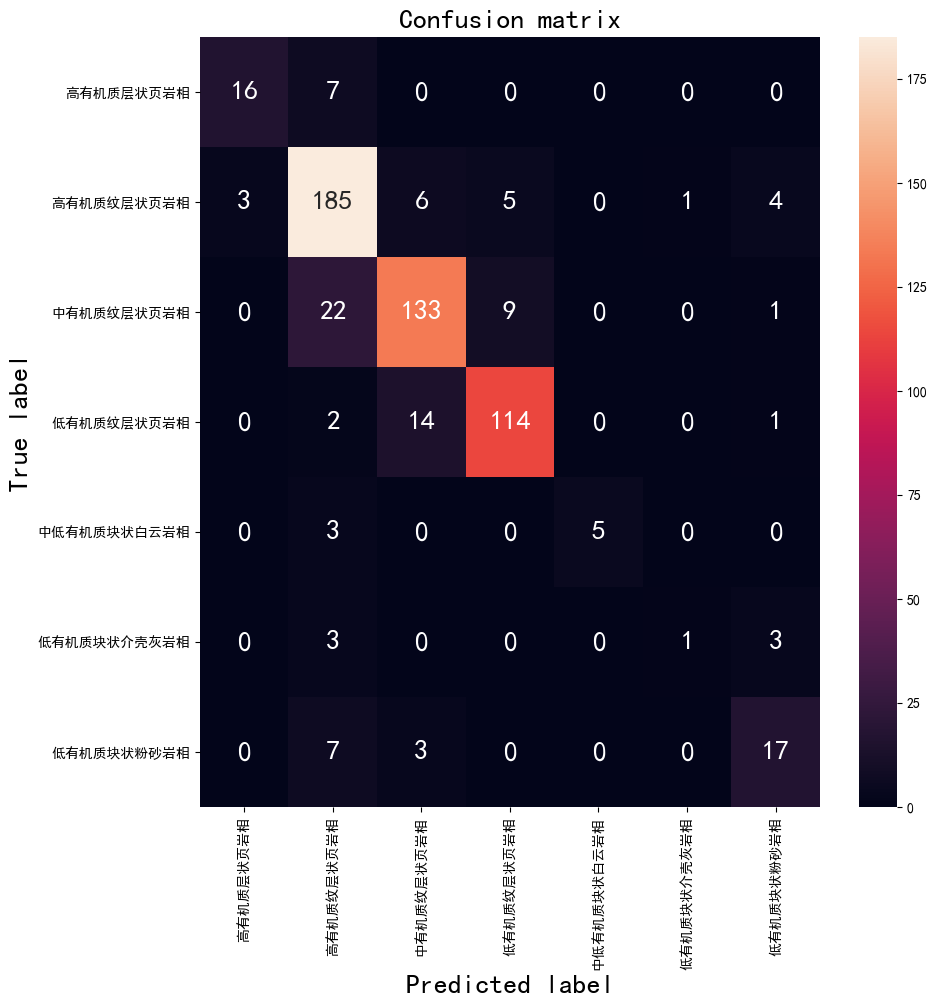

In [33]:
plt.figure(figsize=(10,10))
sns.heatmap(conf, xticklabels=facies_labels, yticklabels=facies_labels, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.savefig(model_training_img_file_saving_path + model_training_img_name  + '_confusion_matrix.png', dpi=330,  bbox_inches='tight')
plt.show()

In [34]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

In [35]:
# adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

In [36]:
adjacent_facies = np.array([[0],[1], [0,1], [1,2,3], [4], [5], [5,6]])

C:\Users\xbs\AppData\Local\Temp\ipykernel_19664\70449198.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  adjacent_facies = np.array([[0],[1], [0,1], [1,2,3], [4], [5], [5,6]])


In [37]:
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

Facies classification accuracy = 0.833628
Adjacent facies classification accuracy = 1.499115


In [38]:
def per_class_accuracy(conf):
    per_class_correct = 0.
    nb_classes = conf.shape[0]
    per_acc = []
    for i in np.arange(0,nb_classes):
        acc = 0
        per_class_correct = conf[i][i]
        per_class_sum = 0
        per_class_sum = per_class_sum + sum(conf[i])
        print(per_class_sum)
        acc = per_class_correct/per_class_sum
#         acc = per_class_correct/sum(sum(conf))
        per_acc.append(acc)
    return per_acc

In [39]:
per_class_accuracy_list = per_class_accuracy(conf)
for i in range(len(per_class_accuracy_list)):
    print(i,' class facies classification accuracy = %f' % per_class_accuracy_list[i])

23
204
165
131
8
7
27
0  class facies classification accuracy = 0.695652
1  class facies classification accuracy = 0.906863
2  class facies classification accuracy = 0.806061
3  class facies classification accuracy = 0.870229
4  class facies classification accuracy = 0.625000
5  class facies classification accuracy = 0.142857
6  class facies classification accuracy = 0.629630


## Calculate ROC

see: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html?highlight=decision_function  
if hasattr(clf, "decision_function"):  
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])  
        else:  
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

In [40]:
y_score = clf.predict_proba(X_test) 
y_score

array([[0.00209777, 0.11324061, 0.84688526, 0.02934902, 0.00175643,
        0.00184045, 0.00483042],
       [0.00009206, 0.99799937, 0.00007587, 0.00005616, 0.00135876,
        0.0000123 , 0.00040541],
       [0.00000617, 0.00013628, 0.99908924, 0.00070218, 0.00001264,
        0.00000928, 0.00004424],
       [0.00000908, 0.00015351, 0.9991722 , 0.00043901, 0.00001283,
        0.00001485, 0.00019851],
       [0.00031527, 0.52815646, 0.4678574 , 0.00051773, 0.00083245,
        0.0002919 , 0.00202881],
       [0.0000053 , 0.00001378, 0.00018092, 0.99978405, 0.00000615,
        0.00000425, 0.00000555],
       [0.00004688, 0.00094298, 0.09641824, 0.00019681, 0.00050591,
        0.00069022, 0.901199  ],
       [0.01084728, 0.9854586 , 0.0026877 , 0.00005457, 0.0002663 ,
        0.00006985, 0.00061576],
       [0.00034924, 0.00906486, 0.9779455 , 0.00107365, 0.0041202 ,
        0.00195001, 0.00549661],
       [0.00004477, 0.00031849, 0.24881709, 0.7503758 , 0.0001477 ,
        0.00003422, 0.0

In [41]:
import tensorflow as tf
y = tf.keras.utils.to_categorical(y_test,num_classes=len(facies_labels))
y

array([[0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
 

In [42]:
from sklearn.metrics import roc_curve, auc

#decision_function对于SVC返回每个样本距离决策边界的距离
#decision_function对于LR返回预测样本的置信度分数——该样本与超平面的有符号距离

n_classes = len(facies_labels)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])   
    #y_test样例真实标签，y_score学习器预测的样例的概率 
    roc_auc[i] = auc(fpr[i], tpr[i])   
    #计算ROC曲线下方的面积，fpr假正例率数组(横坐标)，tpr真正例率数组(纵坐标） 

In [43]:
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())   #ravel函数将矩阵展开成向量
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [44]:
y.ravel(),y.ravel().shape

(array([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 

In [45]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))   #np.concatenate将“特征维度相同数组”纵向拼接

    # Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)   #np.zeros_like创建一个和参数all_fpr数组维度相同的全0数组
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])   
        #interp一维线性插值，fpr和tpr是插值结点横纵坐标，all_fpr是已知中间节点横坐标(得到插值曲线后，求其纵坐标)
    #https://docs.scipy.org/doc/numpy/reference/generated/numpy.interp.html#numpy.interp

    # Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

C:\Users\xbs\AppData\Local\Temp\ipykernel_19664\1803997550.py:6: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


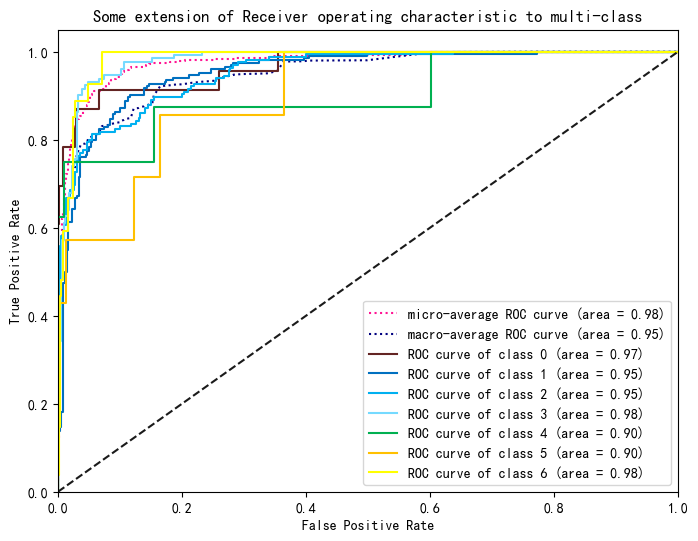

In [46]:
plt.rcParams['figure.figsize']=(8,6)
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})' ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':')

plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:0.2f})' ''.format(roc_auc["macro"]),
             color='navy', linestyle=':')

    # colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])   #python3里的无穷循环器
# colors = facies_colors
for i, color_use in zip(range(n_classes), facies_colors):
    plt.plot(fpr[i], tpr[i], color = color_use, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig(model_training_img_file_saving_path + model_training_img_name  + '_ROC.png', dpi=330,  bbox_inches='tight')
plt.show()

In [47]:
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

Facies classification accuracy = 0.833628
Adjacent facies classification accuracy = 1.499115


In [48]:
# from sklearn.externals import joblib
import joblib
joblib.dump(clf, model_file)

['model/facies_xgboost_train/facies_xgboost_.pkl']

# Applying the classification model to the blind data

In [49]:
TestDataPath = 'facies_data/test/'

In [50]:
filename_A =  '英斜-58井_facies_vectors_0.1.csv'    # 奥-34井_facies_vectors_0.02.csv    # 赵-2911井_facies_vectors_0.02.csv

In [51]:
addR_well_name = filename_A.split(".")[0]
TestDataPath = os.path.join(TestDataPath,filename_A)
addR_well_name

'英斜-58井_facies_vectors_0'

In [52]:
A_read = pd.read_csv(TestDataPath,engine='python',encoding='GBK')
blind  = A_read.dropna()

In [53]:
well_name = np.unique(blind["Well Name"])[0]
well_name

'YX-58'

In [54]:
blind

,DEPTH,CAL,SP,GR,CNL,DT,DEN,MSFL,RS,RD,Facies,Well Name
0,2012.3,9.3512,162.5924,133.0452,22.5484,98.0852,2.3972,4.5072,5.2958,4.8964,6,YX-58
1,2012.4,9.3496,162.6872,134.7578,22.5156,98.1316,2.3984,4.6278,5.1578,4.7058,6,YX-58
2,2012.5,9.3360,162.8000,135.6130,22.4660,98.1660,2.4080,4.6110,5.1530,4.6730,6,YX-58
3,2012.6,9.3232,162.8720,135.7674,22.5372,98.6876,2.4192,4.6086,5.2818,4.7770,2,YX-58
4,2012.7,9.3194,162.9254,135.9260,22.5154,99.3286,2.4298,4.5486,5.4064,4.8762,2,YX-58
...,...,...,...,...,...,...,...,...,...,...,...,...
1087,2121.0,8.6860,167.7170,138.9920,19.5630,91.9960,2.5790,6.6650,5.4110,4.8130,3,YX-58
1088,2121.1,8.7100,167.8194,133.5352,19.7814,89.8688,2.5622,6.2690,5.7942,5.1658,6,YX-58
1089,2121.2,8.7220,167.7712,126.5028,19.7904,87.2976,2.5448,7.2152,6.4504,5.7964,6,YX-58
1090,2121.3,8.7248,167.6516,120.2804,19.4012,84.6108,2.5292,10.1568,7.3772,6.7212,6,YX-58


In [55]:
clf = joblib.load(model_file)

In [56]:
y_blind = blind['Facies'].values

In [57]:
well_features = blind.drop(['Well Name','Facies','DEPTH','CAL','SP'], axis=1)

In [58]:
X_blind = scaler.transform(well_features)

In [59]:
y_pred = clf.predict(X_blind)
blind['Prediction'] = y_pred

In [60]:
cv_conf = confusion_matrix(y_blind, y_pred)

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.50
Optimized adjacent facies classification accuracy = 1.12


In [61]:
display_cm(cv_conf, facies_labels,
           display_metrics=True, hide_zeros=True)

     Pred   高有机质层状页岩相  高有机质纹层状页岩相  中有机质纹层状页岩相  低有机质纹层状页岩相 中低有机质块状白云岩相 低有机质块状介壳灰岩相  低有机质块状粉砂岩相       Total
     True
      高有机质层状页岩相          38           4                                                                      42
     高有机质纹层状页岩相          24         419          61          10           7                       3         524
     中有机质纹层状页岩相           4         199          86          14           1                                 304
     低有机质纹层状页岩相                       6           7                                                          13
    中低有机质块状白云岩相           6          63           5                                               1          75
    低有机质块状介壳灰岩相                      18          13                       3           1           9          44
     低有机质块状粉砂岩相                      62          24           1                                   3          90

Precision        0.53        0.54        0.44        0.00        0.00        1.00        0.19      

e:\论文撰写\基于井相似性的样本权重迁移的测井评价方法\code\Facies_classification_TF2.X\classification_utilities.py:13: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * (precision * recall) / (precision + recall)


In [62]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies,
               display_metrics=True, hide_zeros=True)

     Pred   高有机质层状页岩相  高有机质纹层状页岩相  中有机质纹层状页岩相  低有机质纹层状页岩相 中低有机质块状白云岩相 低有机质块状介壳灰岩相  低有机质块状粉砂岩相       Total
     True
      高有机质层状页岩相                       4                                                                       4
     高有机质纹层状页岩相          24                      61          10           7                       3         105
     中有机质纹层状页岩相                                 289          14           1                                 304
     低有机质纹层状页岩相                                                                                               0
    中低有机质块状白云岩相           6          63           5                                               1          75
    低有机质块状介壳灰岩相                      18          13                       3                       9          43
     低有机质块状粉砂岩相                      62          24           1                                              87

Precision        0.00        0.00        0.74        0.00        0.00        0.00        0.00      

e:\论文撰写\基于井相似性的样本权重迁移的测井评价方法\code\Facies_classification_TF2.X\classification_utilities.py:11: RuntimeWarning: invalid value encountered in true_divide
  precision = np.diagonal(cm)/cm.sum(axis=0).astype('float')
e:\论文撰写\基于井相似性的样本权重迁移的测井评价方法\code\Facies_classification_TF2.X\classification_utilities.py:12: RuntimeWarning: invalid value encountered in true_divide
  recall = np.diagonal(cm)/cm.sum(axis=1).astype('float')


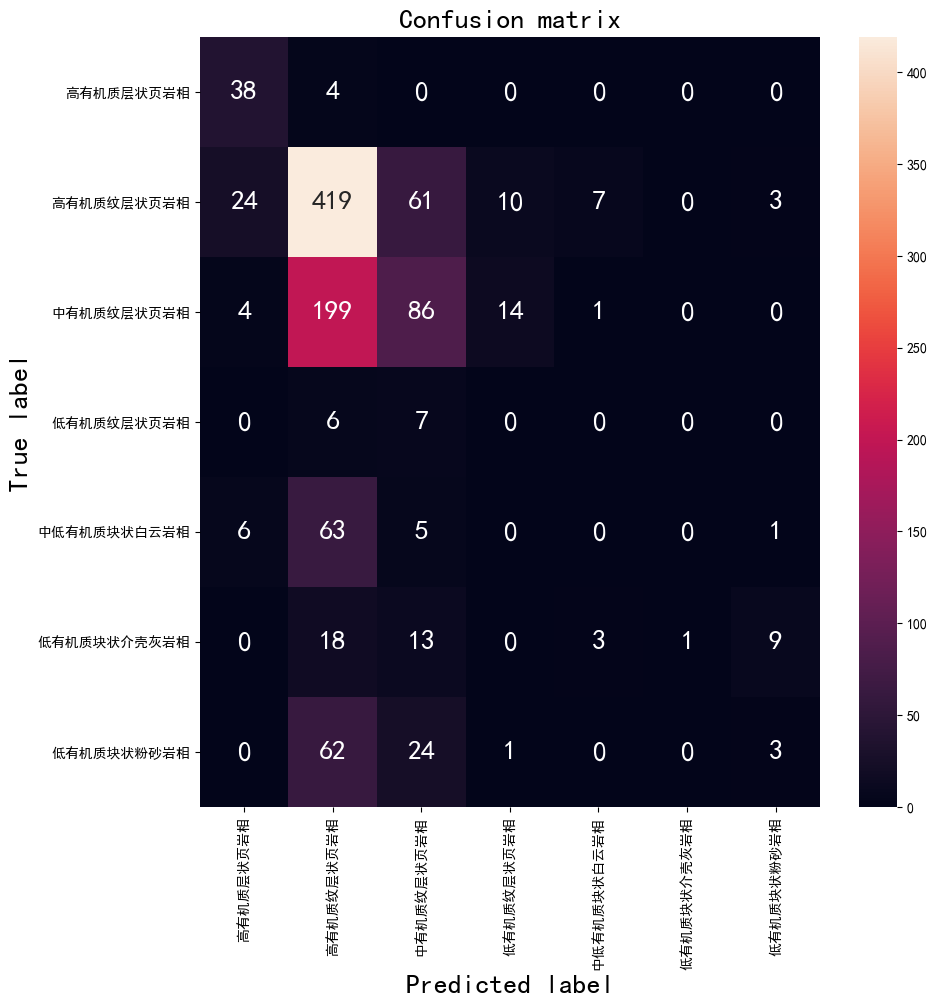

In [63]:
plt.figure(figsize=(10,10))
sns.heatmap(cv_conf, xticklabels=facies_labels, yticklabels=facies_labels, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.xlabel('Predicted label', fontsize=20)
plt.savefig(model_testing_img_file_saving_path + model_testing_image_name + str(well_name) + '_val_confusion_matrix.png', dpi=330,  bbox_inches='tight')
plt.show()

In [64]:
per_class_accuracy_list = per_class_accuracy(cv_conf)
for i in range(len(per_class_accuracy_list)):
    print(i,' class facies classification accuracy = %3f' % per_class_accuracy_list[i])

42
524
304
13
75
44
90
0  class facies classification accuracy = 0.904762
1  class facies classification accuracy = 0.799618
2  class facies classification accuracy = 0.282895
3  class facies classification accuracy = 0.000000
4  class facies classification accuracy = 0.000000
5  class facies classification accuracy = 0.022727
6  class facies classification accuracy = 0.033333


In [65]:
y_score = clf.predict_proba(X_blind) 
y_score

array([[0.00000645, 0.00006855, 0.99796057, ..., 0.00002063, 0.00001   ,
        0.00006059],
       [0.00001418, 0.00020572, 0.9986739 , ..., 0.00004486, 0.00002174,
        0.00013608],
       [0.00001081, 0.0001526 , 0.99908507, ..., 0.00006137, 0.00001657,
        0.00003742],
       ...,
       [0.0000917 , 0.00422853, 0.9893265 , ..., 0.00034611, 0.00009045,
        0.00138978],
       [0.00054588, 0.01799624, 0.9655717 , ..., 0.01021497, 0.00023007,
        0.00234998],
       [0.00223992, 0.05223136, 0.87421244, ..., 0.04937503, 0.00279525,
        0.00354473]], dtype=float32)

In [66]:
import tensorflow as tf
y = tf.keras.utils.to_categorical(y_blind-1,num_classes=len(facies_labels))
y

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [67]:
# from sklearn.metrics import roc_curve, auc

#decision_function对于SVC返回每个样本距离决策边界的距离
#decision_function对于LR返回预测样本的置信度分数——该样本与超平面的有符号距离

n_classes = len(facies_labels)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])   
    #y_test样例真实标签，y_score学习器预测的样例的概率 
    roc_auc[i] = auc(fpr[i], tpr[i])   
    #计算ROC曲线下方的面积，fpr假正例率数组(横坐标)，tpr真正例率数组(纵坐标） 

In [68]:
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())   #ravel函数将矩阵展开成向量
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [69]:
y.ravel(),y.ravel().shape

(array([0., 0., 0., ..., 0., 1., 0.], dtype=float32), (7644,))

In [70]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))   #np.concatenate将“特征维度相同数组”纵向拼接

    # Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)   #np.zeros_like创建一个和参数all_fpr数组维度相同的全0数组
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])   
        #interp一维线性插值，fpr和tpr是插值结点横纵坐标，all_fpr是已知中间节点横坐标(得到插值曲线后，求其纵坐标)
    #https://docs.scipy.org/doc/numpy/reference/generated/numpy.interp.html#numpy.interp

    # Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

C:\Users\xbs\AppData\Local\Temp\ipykernel_19664\1803997550.py:6: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


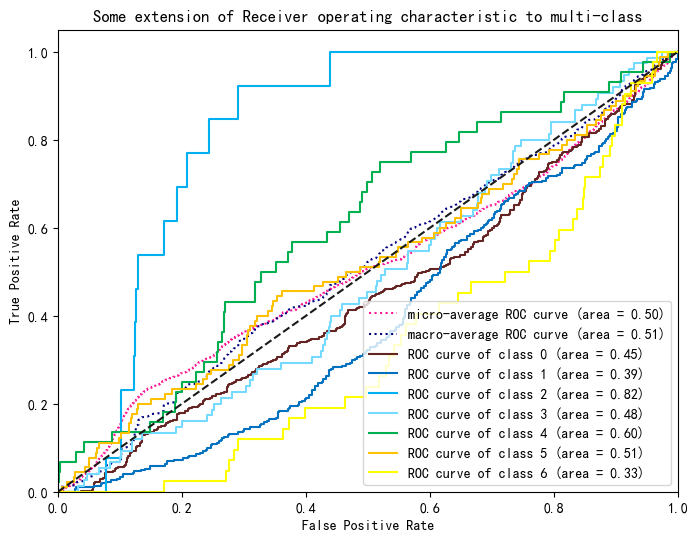

In [71]:
plt.rcParams['figure.figsize']=(8,6)
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})' ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':')

plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:0.2f})' ''.format(roc_auc["macro"]),
             color='navy', linestyle=':')

    # colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])   #python3里的无穷循环器
# colors = facies_colors
for i, color_use in zip(range(n_classes), facies_colors):
    plt.plot(fpr[i], tpr[i], color = color_use, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig(model_testing_img_file_saving_path + model_testing_image_name  +  str(well_name) + '_ROC.png', dpi=220,  bbox_inches='tight')
plt.show()

In [72]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='DEPTH')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.DEPTH.min(); zbot=logs.DEPTH.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.DEPTH, '-g')
    ax[1].plot(logs.ILD_log10, logs.DEPTH, '-')
    ax[2].plot(logs.DeltaPHI, logs.DEPTH, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.DEPTH, '-', color='r')
    ax[4].plot(logs.PE, logs.DEPTH, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

In [73]:
def make_facies_log_plot_4(logs,sample_index, facies_colors):
    #make sure logs are sorted by depth
    # logs = logs.sort_values(by = DEPTH_col_name)
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    # sample_index = np.arange(len(AB_G))
    ztop=logs[DEPTH_col_name].min(); zbot=logs[DEPTH_col_name].max()
    # ztop = 0; zbot = len(logs)
    
    cluster1 = np.repeat(np.expand_dims(logs["Prediction"].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[facies_labels_col].values,1), 100, 1)
    total_fig_cols = len(input_vectors)+ 2
    f, ax = plt.subplots(nrows=1, ncols=len(input_vectors) + 2, figsize=(total_fig_cols * 2,15))
    for i in range(len(input_vectors)):
        # ax[i].plot(logs[input_vectors[i]], sample_index)
        ax[i].plot(logs[input_vectors[i]], logs[DEPTH_col_name])  
    final_line = len(input_vectors)
    if model_stage == "train":
        im1 = ax[final_line].imshow(cluster1, interpolation='none', aspect='auto',
                        cmap=cmap_facies,vmin = 1,vmax = len(facies_colors))
        im2 = ax[final_line+1].imshow(cluster2, interpolation='none', aspect='auto',
                        cmap=cmap_facies,vmin = 1,vmax = len(facies_colors))
    
        divider = make_axes_locatable(ax[final_line])
        cax = divider.append_axes("right", size="20%", pad=0.05)
        cbar=plt.colorbar(im2, cax=cax)
        cbar.set_label((3*' ').join(facies_labels))
        cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
        ax[i].set_xlabel(input_vectors[i])
        ax[i].set_xlim(logs[input_vectors[i]].min() - 0.01,logs[input_vectors[i]].max() * 1.02)
        
    for i in range(len(ax)-2):
        ax[i].set_yticklabels([]);
        
    if model_stage == "train" :   
        ax[final_line].set_xlabel('Prediction')
        ax[final_line + 1].set_xlabel('Real Facies')
        ax[final_line].set_yticklabels([])
        ax[final_line].set_xticklabels([])
        ax[final_line + 1].set_yticklabels([])
        ax[final_line + 1].set_xticklabels([])
    # f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)
    f.suptitle("全部样本预测结果", fontsize=14,y=0.94)
    if model_stage == "train":
        pred_image_save_path = model_training_img_file_saving_path 
        pred_image_name = model_training_img_name
    else:
        pred_image_save_path = model_testing_img_file_saving_path 
        pred_image_name = model_testing_image_name
    plt.savefig(pred_image_save_path + pred_image_name + str(well_name) + '_PredictionAll.png', dpi=96,  bbox_inches='tight')

In [74]:
model_stage = "train"

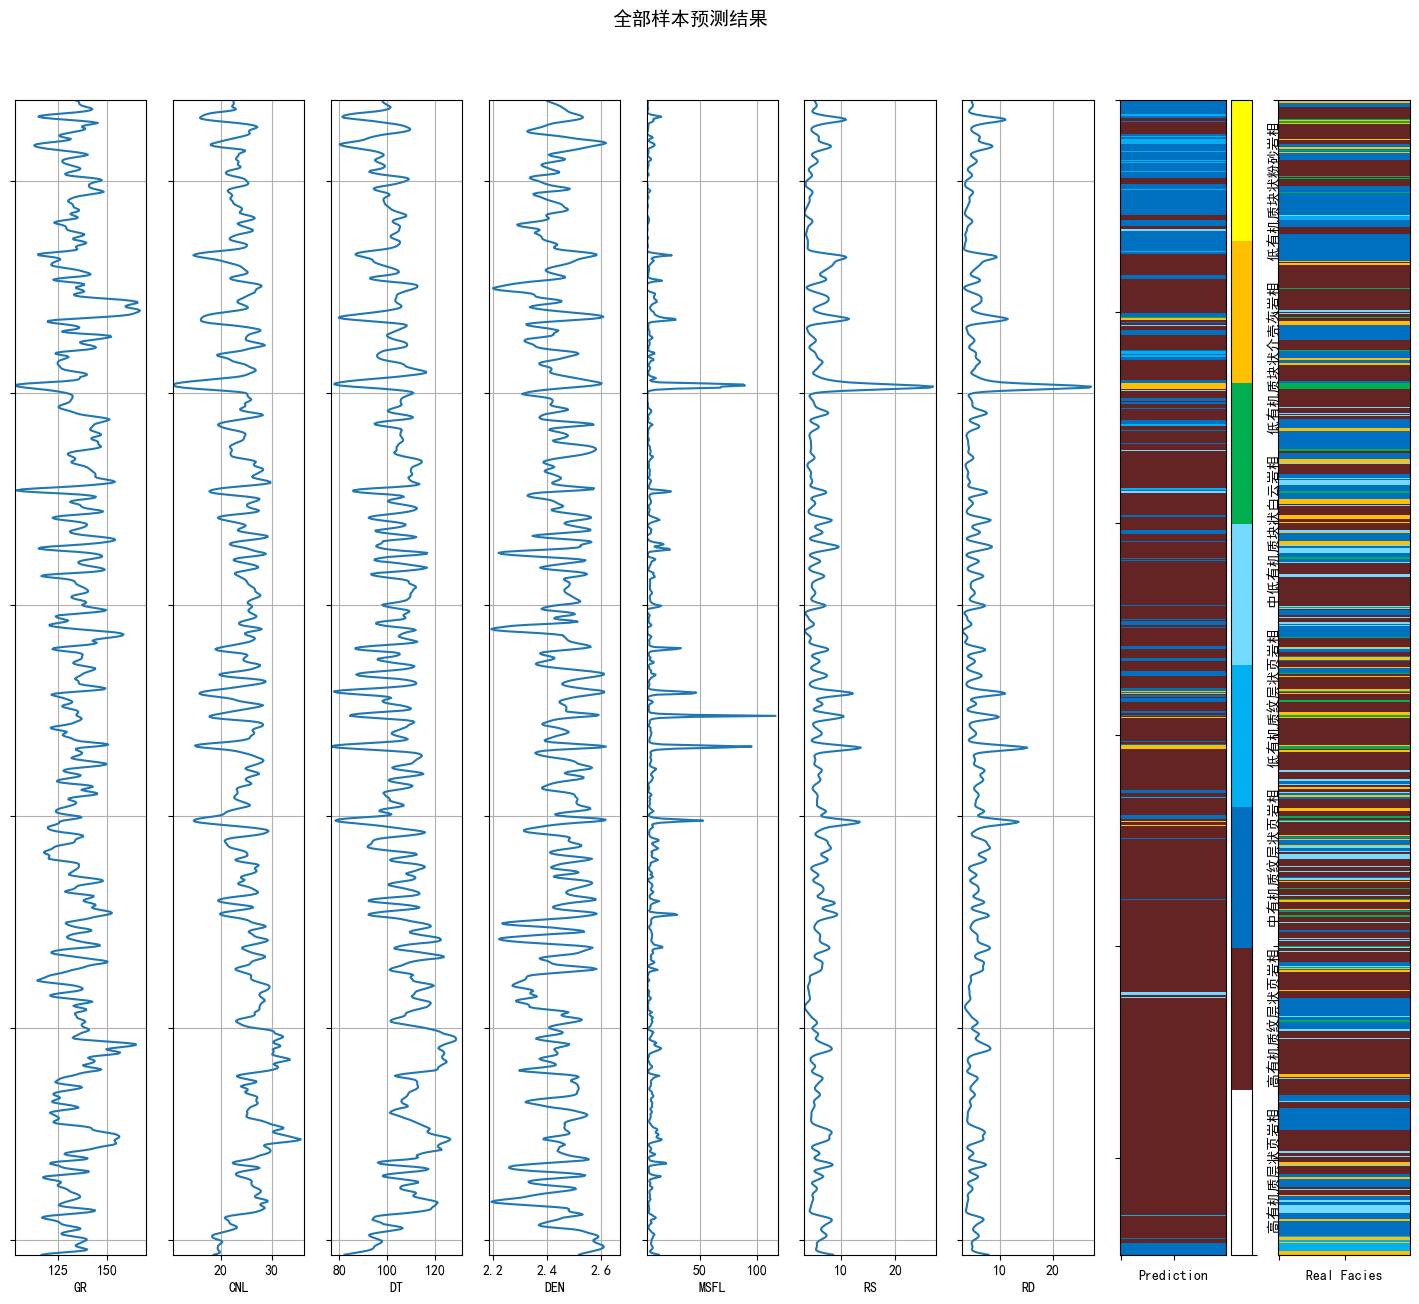

In [75]:
# compare_facies_plot(blind, 'Prediction', facies_colors)
sample_index = np.array(blind[DEPTH_col_name])
make_facies_log_plot_4(blind, sample_index, facies_colors)

In [76]:
model_stage = "test"

In [77]:
csv_file_saving_path = os.path.join("facies_csv_results/")
if model_stage == "test": 
    csv_file_saving_path = os.path.join("facies_csv_results/", "xgboost_test/")
else:
    csv_file_saving_path = os.path.join("facies_csv_results/", "xgboost_train/")
if not os.path.exists(csv_file_saving_path):
    os.mkdir(csv_file_saving_path)
print(csv_file_saving_path)

result_csv_name = str(well_name) +  '_Xgboost-Pred_R_'+'.txt'
print(result_csv_name)

facies_csv_results/xgboost_test/
YX-58_Xgboost-Pred_R_.txt


In [78]:
blind.to_csv(os.path.join(csv_file_saving_path,result_csv_name),encoding = 'GBK',mode='w',float_format='%.4f',sep='\t',index=None,header=True)

# Applying the classification model to new data

In [79]:
TestDataPath = 'facies_data/test/'
filename_A = '英斜-58井_facies_vectors_0.1.csv'
TestDataPath = os.path.join(TestDataPath,filename_A)
well_data = pd.read_csv(TestDataPath)
well_data['Well Name'] = well_data['Well Name'].astype('category')
well_features = well_data.drop(['Formation', 'Well Name', 'DEPTH'], axis=1)

KeyError: "['Formation'] not found in axis"

In [ ]:
X_unknown = scaler.transform(well_features)

In [ ]:
clf = joblib.load(model_file)

In [ ]:
#predict facies of unclassified data
y_unknown = clf.predict(X_unknown)
well_data['Facies'] = y_unknown
well_data

In [ ]:
well_data['Well Name'].unique()

In [ ]:
make_facies_log_plot(
    well_data[well_data['Well Name'] == 'STUART'],
    facies_colors=facies_colors)

make_facies_log_plot(
    well_data[well_data['Well Name'] == 'CRAWFORD'],
    facies_colors=facies_colors)

In [ ]:
well_data.to_csv('well_data_with_facies.csv')

Modified by Reference  
Amato del Monte, A., 2015. Seismic Petrophysics: Part 1, The Leading Edge, 34 (4). doi:10.1190/tle34040440.1

Bohling, G. C., and M. K. Dubois, 2003. An Integrated Application of Neural Network and Markov Chain Techniques to Prediction of Lithofacies from Well Logs, KGS Open-File Report 2003-50, 6 pp. pdf

Dubois, M. K., G. C. Bohling, and S. Chakrabarti, 2007, Comparison of four approaches to a rock facies classification problem, Computers & Geosciences, 33 (5), 599-617 pp. doi:10.1016/j.cageo.2006.08.011
https://github.com/seg/tutorials-2016/blob/master/1610_Facies_classification